In [1]:
import sys
import os

try:
    # If running from a .py file
    base_path = os.path.dirname(__file__)
except NameError:
    # If running in Jupyter Notebook
    base_path = os.getcwd()

project_root = os.path.abspath(os.path.join(base_path, ".."))
sys.path.append(project_root)

from rsp.ReliableSpacePredictor import *

/Applications/anaconda3/envs/3DFuse/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [26]:
def collect_trial_metrics(results):
    results_global, results_RSP = results
    metrics_all_trials = []

    for i in range(len(results_global)):  
        global_perf = results_global[i]['performance']
        RSP_perf = results_RSP[i]['performance']
        RSP_uq = results_RSP[i]['conformal']['conformal_accuracy_metrics_combined']
        dist_err_corr = results_RSP[i]['distance_error_analysis']
        clf_df = results_RSP[i]['classification_results']

        trial_metrics = {
            'global': {},
            'RSP': {},
            'RSP_classification': clf_df,
            'RSP_correlation': dist_err_corr
        }

        for method in global_perf:
            trial_metrics['global'][method] = {
                'rmse': global_perf[method]['rmse'],
                'r2': global_perf[method]['r2']
            }
            trial_metrics['RSP'][method] = {
                'rmse': RSP_perf[method]['rmse'],
                'r2': RSP_perf[method]['r2'],
                'coverage_dcp': RSP_uq.get(method, {}).get('coverage_dcp', np.nan),
                'coverage_fcp': RSP_uq.get(method, {}).get('coverage_fcp', np.nan),
                'dcp_width': RSP_uq.get(method, {}).get('dcp_interval_mean_width', np.nan),
                'dcp_width_std': RSP_uq.get(method, {}).get('dcp_interval_width_std', np.nan),
                'fcp_width': RSP_uq.get(method, {}).get('fcp_interval_mean_width', np.nan)
            }

        metrics_all_trials.append(trial_metrics)
    
    return metrics_all_trials


# def summarize_validation_results(metrics_all_trials):
#     rmse_true_global, rmse_true_rsp = [], []
#     r2_true_global, r2_true_rsp = [], []
#     pearson_train, pearson_test = [], []
#     dcp_cov, fcp_cov = [], []
#     dcp_w, dcp_std, fcp_w = [], [], []

#     clf_summary_rows = []

#     # Map display names to actual dictionary keys
#     approach_map = {
#         'Distance': 'distance',
#         'Classifier': 'classifier',
#         'Distance-aware Classifier': 'distance_bin',
#         'Combined 1': 'combined_1',
#         'Combined 2': 'combined_2',
#         'Combined 3': 'combined_3',
#         'Combined 4': 'combined_4'
#     }

#     for trial in metrics_all_trials:
#         # 1. RMSE/R² on 'true'
#         rmse_true_global.append(trial['global']['true']['rmse'])
#         rmse_true_rsp.append(trial['RSP']['true']['rmse'])
#         r2_true_global.append(trial['global']['true']['r2'])
#         r2_true_rsp.append(trial['RSP']['true']['r2'])

#         # 2. Distance–error correlation
#         pearson_train.append(trial['RSP_correlation']['pearson_train_abs'])
#         pearson_test.append(trial['RSP_correlation']['pearson_test_abs'])

#         # 3. Confidence interval metrics
#         dcp_cov.append(trial['RSP']['true']['coverage_dcp'])
#         fcp_cov.append(trial['RSP']['true']['coverage_fcp'])
#         dcp_w.append(trial['RSP']['true']['dcp_width'])
#         dcp_std.append(trial['RSP']['true']['dcp_width_std'])
#         fcp_w.append(trial['RSP']['true']['fcp_width'])

#         # 4. Classifier metrics
#         clf_df = trial['RSP_classification']
#         for _, row in clf_df.iterrows():
#             mapped_key = approach_map.get(row['Approach'], None)
#             clf_summary_rows.append({
#                 'Approach': row['Approach'],
#                 'Accuracy': row['Accuracy'],
#                 'Precision': row['Precision'],
#                 'TPR': row['TPR'],
#                 'FPR': row['FPR'],
#                 'F1 Score': row['F1 Score'],
#                 'Coverage': row['Coverage'],
#                 'RMSE (Global)': trial['global'].get(mapped_key, {}).get('rmse', np.nan) if mapped_key else np.nan,
#                 'RMSE (RSP)': trial['RSP'].get(mapped_key, {}).get('rmse', np.nan) if mapped_key else np.nan,
#                 'RSP_better': int(
#                     trial['RSP'].get(mapped_key, {}).get('rmse', np.inf) <
#                     trial['global'].get(mapped_key, {}).get('rmse', np.inf)
#                 ) if mapped_key else np.nan
#             })

#     # Display summaries
#     print("=== RMSE and R² (TRUE IN-DOMAIN) ===")
#     print(pd.DataFrame({
#         'Global RMSE': [np.mean(rmse_true_global), np.std(rmse_true_global)],
#         'RSP RMSE': [np.mean(rmse_true_rsp), np.std(rmse_true_rsp)],
#         'Global R²': [np.mean(r2_true_global), np.std(r2_true_global)],
#         'RSP R²': [np.mean(r2_true_rsp), np.std(r2_true_rsp)]
#     }, index=['Mean', 'Std']))

#     print("\n=== DISTANCE–ERROR CORRELATION ===")
#     print(pd.DataFrame({
#         'Train': [np.mean(pearson_train), np.std(pearson_train)],
#         'Test': [np.mean(pearson_test), np.std(pearson_test)]
#     }, index=['Mean', 'Std']))

#     print("\n=== UQ METRICS for TRUE DOMAIN (RSP) ===")
#     print(pd.DataFrame({
#         'DCP Coverage': [np.mean(dcp_cov), np.std(dcp_cov)],
#         'DCP Width': [np.mean(dcp_w), np.std(dcp_w)],
#         'DCP Width Std': [np.mean(dcp_std), np.std(dcp_std)],
#         'FCP Coverage': [np.mean(fcp_cov), np.std(fcp_cov)],
#         'FCP Width': [np.mean(fcp_w), np.std(fcp_w)]
#     }, index=['Mean', 'Std']))

#     print("\n=== CLASSIFICATION METRIC COMPARISON ===")
#     df_clf = pd.DataFrame(clf_summary_rows)

#     # Count how often RSP RMSE is better than global RMSE
#     rmse_win_counts = df_clf.groupby('Approach')['RSP_better'].sum().astype(int).rename('RSP better count').to_frame()

#     # Remove extra column before aggregation
#     df_clf = df_clf.drop(columns='RSP_better')

#     summary_clf = df_clf.groupby('Approach').agg(['mean', 'std']).round(4)

#     # Flatten MultiIndex before merging
#     summary_clf.columns = [' '.join(col).strip() for col in summary_clf.columns.values]

#     # Merge win counts
#     summary_clf = summary_clf.merge(rmse_win_counts, left_index=True, right_index=True)


#     display(summary_clf)
#     return summary_clf


In [173]:
def summarize_validation_results(metrics_all_trials):
    rmse_true_global, rmse_true_rsp = [], []
    r2_true_global, r2_true_rsp = [], []
    pearson_train, pearson_test = [], []
    dcp_cov, fcp_cov = [], []
    dcp_w, dcp_std, fcp_w = [], [], []

    clf_summary_rows = []

    # Map display names to actual dictionary keys
    approach_map = {
        'Distance': 'distance',
        'Classifier': 'classifier',
        'Distance-aware Classifier': 'distance_bin',
        'Combined 1': 'combined_1',
        'Combined 2': 'combined_2',
        'Combined 3': 'combined_3',
        'Combined 4': 'combined_4'
    }

    for trial in metrics_all_trials:
        # 1. RMSE/R² on 'true'
        rmse_true_global.append(trial['global']['true']['rmse'])
        rmse_true_rsp.append(trial['RSP']['true']['rmse'])
        r2_true_global.append(trial['global']['true']['r2'])
        r2_true_rsp.append(trial['RSP']['true']['r2'])

        # 2. Distance–error correlation
        pearson_train.append(trial['RSP_correlation']['pearson_train_abs'])
        pearson_test.append(trial['RSP_correlation']['pearson_test_abs'])

        # 3. Confidence interval metrics (on 'true' only)
        dcp_cov.append(trial['RSP']['true']['coverage_dcp'])
        fcp_cov.append(trial['RSP']['true']['coverage_fcp'])
        dcp_w.append(trial['RSP']['true']['dcp_width'])
        dcp_std.append(trial['RSP']['true']['dcp_width_std'])
        fcp_w.append(trial['RSP']['true']['fcp_width'])

        # 4. Classifier metrics and UQ results per subset
        clf_df = trial['RSP_classification']
        for _, row in clf_df.iterrows():
            mapped_key = approach_map.get(row['Approach'], None)
            RSP_sub = trial['RSP'].get(mapped_key, {}) if mapped_key else {}
            clf_summary_rows.append({
                'Approach': row['Approach'],
                'Accuracy': row['Accuracy'],
                'Precision': row['Precision'],
                'TPR': row['TPR'],
                'FPR': row['FPR'],
                'F1 Score': row['F1 Score'],
                'Coverage': row['Coverage'],
                'RMSE (Global)': trial['global'].get(mapped_key, {}).get('rmse', np.nan),
                'RMSE (RSP)': RSP_sub.get('rmse', np.nan),
                'Coverage DCP': RSP_sub.get('coverage_dcp', np.nan),
                'Coverage FCP': RSP_sub.get('coverage_fcp', np.nan),
                'Width DCP': RSP_sub.get('dcp_width', np.nan),
                'Width FCP': RSP_sub.get('fcp_width', np.nan),
                'RSP_better': int(
                    RSP_sub.get('rmse', np.inf) < trial['global'].get(mapped_key, {}).get('rmse', np.inf)
                ) if mapped_key else np.nan
            })

    # Display summaries
    print("=== RMSE and R² (TRUE IN-DOMAIN) ===")
    print(pd.DataFrame({
        'Global RMSE': [np.mean(rmse_true_global), np.std(rmse_true_global)],
        'RSP RMSE': [np.mean(rmse_true_rsp), np.std(rmse_true_rsp)],
        'Global R²': [np.mean(r2_true_global), np.std(r2_true_global)],
        'RSP R²': [np.mean(r2_true_rsp), np.std(r2_true_rsp)]
    }, index=['Mean', 'Std']))

    print("\n=== DISTANCE–ERROR CORRELATION ===")
    print(pd.DataFrame({
        'Train': [np.mean(pearson_train), np.std(pearson_train)],
        'Test': [np.mean(pearson_test), np.std(pearson_test)]
    }, index=['Mean', 'Std']))

    print("\n=== UQ METRICS for TRUE DOMAIN (RSP) ===")
    print(pd.DataFrame({
        'DCP Coverage': [np.mean(dcp_cov), np.std(dcp_cov)],
        'DCP Width': [np.mean(dcp_w), np.std(dcp_w)],
        'DCP Width Std': [np.mean(dcp_std), np.std(dcp_std)],
        'FCP Coverage': [np.mean(fcp_cov), np.std(fcp_cov)],
        'FCP Width': [np.mean(fcp_w), np.std(fcp_w)]
    }, index=['Mean', 'Std']))

    print("\n=== CLASSIFICATION METRIC COMPARISON + UQ ===")
    df_clf = pd.DataFrame(clf_summary_rows)

    # Count how often RSP RMSE is better than global RMSE
    rmse_win_counts = df_clf.groupby('Approach')['RSP_better'].sum().astype(int).rename('RSP better count').to_frame()

    # Drop for now to prepare summary table
    df_clf = df_clf.drop(columns='RSP_better')

    summary_clf = df_clf.groupby('Approach').agg(['mean', 'std']).round(4)
    summary_clf.columns = [' '.join(col).strip() for col in summary_clf.columns.values]
    summary_clf = summary_clf.merge(rmse_win_counts, left_index=True, right_index=True)

    display(summary_clf)
    return summary_clf

In [175]:
# Format mean ± std strings
def format_mean_std(mean, std, digits=2):
    return f"{mean:.{digits}f} ± {std:.{digits}f}"

def organize_the_clf_df(df):
    summary_clf_formatted = df.copy()

    # Automatically format mean ± std for all "metric mean" + "metric std" columns
    for col in df:
        if "mean" in col:
            base = col.replace(" mean", "")
            std_col = f"{base} std"
            if std_col in df.columns:
                summary_clf_formatted[base] = [
                    format_mean_std(m, s)
                    for m, s in zip(df[col], df[std_col])
                ]

    # Columns that are now formatted
    formatted_metrics = [
        col.replace(" mean", "") for col in df.columns if col.endswith(" mean")
    ]

    # Keep only the formatted columns and RSP better count
    keep_cols = formatted_metrics + ['RSP better count']
    summary_clf_formatted = summary_clf_formatted[keep_cols]

    display(summary_clf_formatted)
    return summary_clf_formatted


In [120]:
from collections import Counter

# Function to get top descriptors
def get_top_selected_descriptors(results, top_n=20):
    all_descriptors_regressor = []
    all_descriptors_classifier = []

    results_RSP = results[1]

    for result in results_RSP:
        reg_feats = result.get('selected_features_regressor', {}).get('descriptors', [])
        clf_feats = result.get('selected_features_classifier', {}).get('descriptors', [])
        all_descriptors_regressor.extend(reg_feats)
        all_descriptors_classifier.extend(clf_feats)

    reg_counter = Counter(all_descriptors_regressor)
    clf_counter = Counter(all_descriptors_classifier)

    top_reg = reg_counter.most_common(top_n)
    top_clf = clf_counter.most_common(top_n)

    df_top_reg = pd.DataFrame(top_reg, columns=['Descriptor', 'Frequency'])
    df_top_clf = pd.DataFrame(top_clf, columns=['Descriptor', 'Frequency'])

    return df_top_reg, df_top_clf


Fathead Minnow

In [14]:
with open('fm/RSP_results_fm_xgb_041425.pkl', 'rb') as file:
    results_fm = pickle.load(file=file)

In [174]:
metrics_fm = collect_trial_metrics(results_fm)
df_clf_summary_fm = summarize_validation_results(metrics_fm)

=== RMSE and R² (TRUE IN-DOMAIN) ===
      Global RMSE  RSP RMSE  Global R²    RSP R²
Mean     0.758009  0.498791  -1.125845  0.112498
Std      0.094511  0.069731   0.662768  0.146789

=== DISTANCE–ERROR CORRELATION ===
         Train      Test
Mean  0.656339  0.559279
Std   0.069602  0.121640

=== UQ METRICS for TRUE DOMAIN (RSP) ===
      DCP Coverage  DCP Width  DCP Width Std  FCP Coverage  FCP Width
Mean      0.955060   2.100752       0.186524      0.908274   1.739692
Std       0.042436   0.245426       0.074142      0.049083   0.170514

=== CLASSIFICATION METRIC COMPARISON + UQ ===


,Accuracy mean,Accuracy std,Precision mean,Precision std,TPR mean,TPR std,FPR mean,FPR std,F1 Score mean,F1 Score std,...,RMSE (RSP) std,Coverage DCP mean,Coverage DCP std,Coverage FCP mean,Coverage FCP std,Width DCP mean,Width DCP std,Width FCP mean,Width FCP std,RSP better count
Approach,,,,,,,,,,,,,,,,,,,,,
Classifier,0.6888,0.0580,0.7198,0.0842,0.7260,0.1046,0.3703,0.1151,0.6611,0.0640,...,0.1320,0.7500,0.0734,0.6864,0.0797,2.0976,0.2471,1.7397,0.1714,31
Combined 1,0.6851,0.0571,0.7380,0.0855,0.6776,0.1095,0.3141,0.1040,0.6695,0.0606,...,0.1452,0.7590,0.0788,0.6980,0.0881,2.0884,0.2455,1.7397,0.1714,33
Combined 2,0.6791,0.0592,0.7598,0.0902,0.6233,0.1144,0.2577,0.1003,0.6653,0.0681,...,0.1552,0.7794,0.0828,0.7199,0.0922,2.0858,0.2453,1.7397,0.1714,42
Combined 3,0.6841,0.0586,0.7517,0.0867,0.6491,0.1118,0.2808,0.1034,0.6700,0.0655,...,0.1469,0.7766,0.0785,0.7148,0.0858,2.0911,0.2451,1.7397,0.1714,42
Combined 4,0.6791,0.0592,0.7598,0.0902,0.6233,0.1144,0.2577,0.1003,0.6653,0.0681,...,0.1552,0.7794,0.0828,0.7199,0.0922,2.0858,0.2453,1.7397,0.1714,42
Distance,0.6815,0.0569,0.6825,0.0771,0.8101,0.0762,0.4921,0.1014,0.6155,0.0743,...,0.1294,0.7066,0.0779,0.6468,0.0797,2.0872,0.2456,1.7397,0.1714,20
Distance-aware Classifier,0.6841,0.0586,0.7517,0.0867,0.6491,0.1118,0.2808,0.1034,0.6700,0.0655,...,0.1469,0.7766,0.0785,0.7148,0.0858,2.0911,0.2451,1.7397,0.1714,42


In [44]:
improvement_fm = (0.758009 - 0.498791)/0.758009*100
print(f"% improvement: {improvement_fm:.2f} %")

% improvement: 34.20


In [176]:
df_clf_summary_fm_organized = organize_the_clf_df(df_clf_summary_fm)

,Accuracy,Precision,TPR,FPR,F1 Score,Coverage,RMSE (Global),RMSE (RSP),Coverage DCP,Coverage FCP,Width DCP,Width FCP,RSP better count
Approach,,,,,,,,,,,,,
Classifier,0.69 ± 0.06,0.72 ± 0.08,0.73 ± 0.10,0.37 ± 0.12,0.66 ± 0.06,0.57 ± 0.11,0.94 ± 0.12,0.97 ± 0.13,0.75 ± 0.07,0.69 ± 0.08,2.10 ± 0.25,1.74 ± 0.17,31
Combined 1,0.69 ± 0.06,0.74 ± 0.09,0.68 ± 0.11,0.31 ± 0.10,0.67 ± 0.06,0.52 ± 0.10,0.92 ± 0.13,0.95 ± 0.15,0.76 ± 0.08,0.70 ± 0.09,2.09 ± 0.25,1.74 ± 0.17,33
Combined 2,0.68 ± 0.06,0.76 ± 0.09,0.62 ± 0.11,0.26 ± 0.10,0.67 ± 0.07,0.47 ± 0.10,0.89 ± 0.14,0.91 ± 0.16,0.78 ± 0.08,0.72 ± 0.09,2.09 ± 0.25,1.74 ± 0.17,42
Combined 3,0.68 ± 0.06,0.75 ± 0.09,0.65 ± 0.11,0.28 ± 0.10,0.67 ± 0.07,0.49 ± 0.10,0.90 ± 0.13,0.92 ± 0.15,0.78 ± 0.08,0.71 ± 0.09,2.09 ± 0.25,1.74 ± 0.17,42
Combined 4,0.68 ± 0.06,0.76 ± 0.09,0.62 ± 0.11,0.26 ± 0.10,0.67 ± 0.07,0.47 ± 0.10,0.89 ± 0.14,0.91 ± 0.16,0.78 ± 0.08,0.72 ± 0.09,2.09 ± 0.25,1.74 ± 0.17,42
Distance,0.68 ± 0.06,0.68 ± 0.08,0.81 ± 0.08,0.49 ± 0.10,0.62 ± 0.07,0.67 ± 0.08,1.00 ± 0.11,1.06 ± 0.13,0.71 ± 0.08,0.65 ± 0.08,2.09 ± 0.25,1.74 ± 0.17,20
Distance-aware Classifier,0.68 ± 0.06,0.75 ± 0.09,0.65 ± 0.11,0.28 ± 0.10,0.67 ± 0.07,0.49 ± 0.10,0.90 ± 0.13,0.92 ± 0.15,0.78 ± 0.08,0.71 ± 0.09,2.09 ± 0.25,1.74 ± 0.17,42


In [189]:
(0.90-0.92)/0.90*100

-2.222222222222224

In [124]:
# Get top descriptors
df_top_reg, df_top_clf = get_top_selected_descriptors(results_fm, top_n=20)

print("Top descriptors for regression model (RSP):")
df_top_reg

Top descriptors for regression model (RSP):


,Descriptor,Frequency
0,ZMIC3,94
1,NPR2,92
2,ATSC2dv,90
3,qed,88
4,MolLogP,85
5,MaxAbsEStateIndex,85
6,ATSC4dv,83
7,Mv,81
8,Asphericity,81
9,ATSC1Z,80


In [125]:
print("\nTop descriptors for classifier model:")
df_top_clf


Top descriptors for classifier model:


,Descriptor,Frequency
0,y_hat,100
1,PC1,96
2,MolLogP,88
3,PC2,88
4,BalabanJ,84
5,ATS0Z,80
6,Asphericity,79
7,hallKierAlpha,74
8,InertialShapeFactor,73
9,ZMIC3,59


Green Algae

In [28]:
with open('ga/RSP_results_ga_xgb_041425.pkl', 'rb') as file:
    results_ga = pickle.load(file=file)

In [183]:
metrics_ga = collect_trial_metrics(results_ga)
df_clf_summary_ga = summarize_validation_results(metrics_ga)

=== RMSE and R² (TRUE IN-DOMAIN) ===
      Global RMSE  RSP RMSE  Global R²    RSP R²
Mean     0.885441  0.527876  -1.977119  0.027307
Std      0.240582  0.093382   1.802535  0.261802

=== DISTANCE–ERROR CORRELATION ===
         Train      Test
Mean  0.614007  0.475298
Std   0.111313  0.213437

=== UQ METRICS for TRUE DOMAIN (RSP) ===
      DCP Coverage  DCP Width  DCP Width Std  FCP Coverage  FCP Width
Mean      0.929284   2.116697        0.19413      0.874840   1.706505
Std       0.072324   0.373065        0.09216      0.090353   0.270499

=== CLASSIFICATION METRIC COMPARISON + UQ ===


,Accuracy mean,Accuracy std,Precision mean,Precision std,TPR mean,TPR std,FPR mean,FPR std,F1 Score mean,F1 Score std,...,RMSE (RSP) std,Coverage DCP mean,Coverage DCP std,Coverage FCP mean,Coverage FCP std,Width DCP mean,Width DCP std,Width FCP mean,Width FCP std,RSP better count
Approach,,,,,,,,,,,,,,,,,,,,,
Classifier,0.6790,0.0885,0.7347,0.0969,0.8152,0.1303,0.6376,0.2073,0.4509,0.2017,...,0.3942,0.7596,0.1094,0.6958,0.1149,2.1204,0.3771,1.7065,0.2719,55
Combined 1,0.6576,0.0908,0.7502,0.0965,0.7322,0.1380,0.5358,0.2069,0.5234,0.1686,...,0.4440,0.7756,0.1113,0.7107,0.1208,2.1226,0.3782,1.7065,0.2719,37
Combined 2,0.6438,0.0963,0.7667,0.1001,0.6697,0.1492,0.4547,0.2172,0.5542,0.1631,...,0.4406,0.7902,0.1150,0.7255,0.1237,2.1194,0.3790,1.7065,0.2719,50
Combined 3,0.6572,0.0954,0.7631,0.1010,0.7075,0.1441,0.4889,0.2202,0.5459,0.1680,...,0.4170,0.7855,0.1133,0.7202,0.1188,2.1188,0.3770,1.7065,0.2719,55
Combined 4,0.6438,0.0963,0.7667,0.1001,0.6697,0.1492,0.4547,0.2172,0.5542,0.1631,...,0.4406,0.7902,0.1150,0.7255,0.1237,2.1194,0.3790,1.7065,0.2719,50
Distance,0.6741,0.0941,0.7234,0.1016,0.8321,0.1042,0.6780,0.1727,0.4328,0.1857,...,0.3942,0.7496,0.1083,0.6825,0.1181,2.1251,0.3799,1.7065,0.2719,39
Distance-aware Classifier,0.6572,0.0954,0.7631,0.1010,0.7075,0.1441,0.4889,0.2202,0.5459,0.1680,...,0.4170,0.7855,0.1133,0.7202,0.1188,2.1188,0.3770,1.7065,0.2719,55


In [45]:
improvement_ga = (0.885441 - 0.527876)/0.885441*100
print(f"% improvement: {improvement_ga:.2f} %")

% improvement: 40.38 %


In [192]:
0.03/1.07*100

2.8037383177570088

In [184]:
df_clf_summary_ga_organized = organize_the_clf_df(df_clf_summary_ga)

,Accuracy,Precision,TPR,FPR,F1 Score,Coverage,RMSE (Global),RMSE (RSP),Coverage DCP,Coverage FCP,Width DCP,Width FCP,RSP better count
Approach,,,,,,,,,,,,,
Classifier,0.68 ± 0.09,0.73 ± 0.10,0.82 ± 0.13,0.64 ± 0.21,0.45 ± 0.20,0.75 ± 0.15,1.18 ± 0.34,1.13 ± 0.39,0.76 ± 0.11,0.70 ± 0.11,2.12 ± 0.38,1.71 ± 0.27,55
Combined 1,0.66 ± 0.09,0.75 ± 0.10,0.73 ± 0.14,0.54 ± 0.21,0.52 ± 0.17,0.66 ± 0.14,1.07 ± 0.42,1.09 ± 0.44,0.78 ± 0.11,0.71 ± 0.12,2.12 ± 0.38,1.71 ± 0.27,37
Combined 2,0.64 ± 0.10,0.77 ± 0.10,0.67 ± 0.15,0.45 ± 0.22,0.55 ± 0.16,0.60 ± 0.15,1.05 ± 0.42,1.04 ± 0.44,0.79 ± 0.12,0.73 ± 0.12,2.12 ± 0.38,1.71 ± 0.27,50
Combined 3,0.66 ± 0.10,0.76 ± 0.10,0.71 ± 0.14,0.49 ± 0.22,0.55 ± 0.17,0.63 ± 0.15,1.07 ± 0.39,1.04 ± 0.42,0.79 ± 0.11,0.72 ± 0.12,2.12 ± 0.38,1.71 ± 0.27,55
Combined 4,0.64 ± 0.10,0.77 ± 0.10,0.67 ± 0.15,0.45 ± 0.22,0.55 ± 0.16,0.60 ± 0.15,1.05 ± 0.42,1.04 ± 0.44,0.79 ± 0.12,0.73 ± 0.12,2.12 ± 0.38,1.71 ± 0.27,50
Distance,0.67 ± 0.09,0.72 ± 0.10,0.83 ± 0.10,0.68 ± 0.17,0.43 ± 0.19,0.78 ± 0.10,1.10 ± 0.37,1.13 ± 0.39,0.75 ± 0.11,0.68 ± 0.12,2.13 ± 0.38,1.71 ± 0.27,39
Distance-aware Classifier,0.66 ± 0.10,0.76 ± 0.10,0.71 ± 0.14,0.49 ± 0.22,0.55 ± 0.17,0.63 ± 0.15,1.07 ± 0.39,1.04 ± 0.42,0.79 ± 0.11,0.72 ± 0.12,2.12 ± 0.38,1.71 ± 0.27,55


In [135]:
# Get top descriptors
df_top_reg, df_top_clf = get_top_selected_descriptors(results_ga, top_n=20)

print("Top descriptors for regression model (RSP):")
df_top_reg

Top descriptors for regression model (RSP):


,Descriptor,Frequency
0,exactmw,100
1,InertialShapeFactor,93
2,kappa3,88
3,ATSC3se,74
4,CrippenClogP,70
5,AATS0dv,67
6,ATSC2v,67
7,Asphericity,62
8,ATSC2d,62
9,FpDensityMorgan1,57


In [136]:
print("\nTop descriptors for classifier model:")
df_top_clf


Top descriptors for classifier model:


,Descriptor,Frequency
0,y_hat,99
1,CrippenClogP,83
2,kappa3,75
3,NPR2,69
4,ATSC5dv,69
5,ATSC1Z,64
6,AATS0d,62
7,Phi,60
8,ATSC1se,59
9,exactmw,56


Honey Bee

In [34]:
with open('hb/RSP_results_hb_xgb_041425.pkl', 'rb') as file:
    results_hb = pickle.load(file=file)

In [178]:
metrics_hb = collect_trial_metrics(results_hb)
df_clf_summary_hb = summarize_validation_results(metrics_hb)

=== RMSE and R² (TRUE IN-DOMAIN) ===
      Global RMSE  RSP RMSE  Global R²    RSP R²
Mean     1.012975  0.525062  -3.267831 -0.085035
Std      0.165156  0.084112   1.685657  0.224761

=== DISTANCE–ERROR CORRELATION ===
         Train      Test
Mean  0.677785  0.562382
Std   0.080395  0.157374

=== UQ METRICS for TRUE DOMAIN (RSP) ===
      DCP Coverage  DCP Width  DCP Width Std  FCP Coverage  FCP Width
Mean      0.955434   2.391443       0.277620      0.905616   1.841960
Std       0.049896   0.436636       0.125335      0.066238   0.277027

=== CLASSIFICATION METRIC COMPARISON + UQ ===


,Accuracy mean,Accuracy std,Precision mean,Precision std,TPR mean,TPR std,FPR mean,FPR std,F1 Score mean,F1 Score std,...,RMSE (RSP) std,Coverage DCP mean,Coverage DCP std,Coverage FCP mean,Coverage FCP std,Width DCP mean,Width DCP std,Width FCP mean,Width FCP std,RSP better count
Approach,,,,,,,,,,,,,,,,,,,,,
Classifier,0.7344,0.0633,0.7538,0.0882,0.7441,0.0992,0.2828,0.1124,0.7201,0.0715,...,0.3498,0.7623,0.0957,0.7001,0.0956,2.3785,0.4425,1.842,0.2784,46
Combined 1,0.7267,0.0628,0.7693,0.0916,0.6921,0.1054,0.2421,0.1070,0.7131,0.0701,...,0.3672,0.7707,0.0937,0.7129,0.0984,2.3696,0.4393,1.842,0.2784,40
Combined 2,0.7135,0.0611,0.7819,0.0904,0.6406,0.1057,0.2082,0.0977,0.6983,0.0705,...,0.3806,0.7837,0.0880,0.7281,0.0953,2.3650,0.4386,1.842,0.2784,50
Combined 3,0.7192,0.0639,0.7754,0.0880,0.6671,0.1042,0.2247,0.1019,0.7073,0.0720,...,0.3709,0.7805,0.0877,0.7225,0.0938,2.3694,0.4396,1.842,0.2784,51
Combined 4,0.7135,0.0611,0.7819,0.0904,0.6406,0.1057,0.2082,0.0977,0.6983,0.0705,...,0.3806,0.7837,0.0880,0.7281,0.0953,2.3650,0.4386,1.842,0.2784,50
Distance,0.7227,0.0597,0.7265,0.0836,0.7575,0.1020,0.3288,0.1049,0.7013,0.0668,...,0.3173,0.7338,0.0911,0.6727,0.0911,2.3794,0.4422,1.842,0.2784,23
Distance-aware Classifier,0.7192,0.0639,0.7754,0.0880,0.6671,0.1042,0.2247,0.1019,0.7073,0.0720,...,0.3709,0.7805,0.0877,0.7225,0.0938,2.3694,0.4396,1.842,0.2784,51


In [47]:
improvement_hb = (1.012975 - 0.525062)/1.012975*100
print(f"% improvement: {improvement_hb:.2f} %")

% improvement: 48.17 %


In [179]:
df_clf_summary_hb_organized = organize_the_clf_df(df_clf_summary_hb)

,Accuracy,Precision,TPR,FPR,F1 Score,Coverage,RMSE (Global),RMSE (RSP),Coverage DCP,Coverage FCP,Width DCP,Width FCP,RSP better count
Approach,,,,,,,,,,,,,
Classifier,0.73 ± 0.06,0.75 ± 0.09,0.74 ± 0.10,0.28 ± 0.11,0.72 ± 0.07,0.53 ± 0.10,1.20 ± 0.32,1.19 ± 0.35,0.76 ± 0.10,0.70 ± 0.10,2.38 ± 0.44,1.84 ± 0.28,46
Combined 1,0.73 ± 0.06,0.77 ± 0.09,0.69 ± 0.11,0.24 ± 0.11,0.71 ± 0.07,0.48 ± 0.10,1.18 ± 0.33,1.18 ± 0.37,0.77 ± 0.09,0.71 ± 0.10,2.37 ± 0.44,1.84 ± 0.28,40
Combined 2,0.71 ± 0.06,0.78 ± 0.09,0.64 ± 0.11,0.21 ± 0.10,0.70 ± 0.07,0.44 ± 0.09,1.17 ± 0.35,1.15 ± 0.38,0.78 ± 0.09,0.73 ± 0.10,2.37 ± 0.44,1.84 ± 0.28,50
Combined 3,0.72 ± 0.06,0.78 ± 0.09,0.67 ± 0.10,0.22 ± 0.10,0.71 ± 0.07,0.46 ± 0.09,1.19 ± 0.34,1.15 ± 0.37,0.78 ± 0.09,0.72 ± 0.09,2.37 ± 0.44,1.84 ± 0.28,51
Combined 4,0.71 ± 0.06,0.78 ± 0.09,0.64 ± 0.11,0.21 ± 0.10,0.70 ± 0.07,0.44 ± 0.09,1.17 ± 0.35,1.15 ± 0.38,0.78 ± 0.09,0.73 ± 0.10,2.37 ± 0.44,1.84 ± 0.28,50
Distance,0.72 ± 0.06,0.73 ± 0.08,0.76 ± 0.10,0.33 ± 0.10,0.70 ± 0.07,0.56 ± 0.10,1.22 ± 0.30,1.28 ± 0.32,0.73 ± 0.09,0.67 ± 0.09,2.38 ± 0.44,1.84 ± 0.28,23
Distance-aware Classifier,0.72 ± 0.06,0.78 ± 0.09,0.67 ± 0.10,0.22 ± 0.10,0.71 ± 0.07,0.46 ± 0.09,1.19 ± 0.34,1.15 ± 0.37,0.78 ± 0.09,0.72 ± 0.09,2.37 ± 0.44,1.84 ± 0.28,51


In [191]:
(1.19-1.15)/1.19*100

3.361344537815129

In [133]:
# Get top descriptors
df_top_reg, df_top_clf = get_top_selected_descriptors(results_hb, top_n=20)

print("Top descriptors for regression model (RSP):")
df_top_reg

Top descriptors for regression model (RSP):


,Descriptor,Frequency
0,ATSC5se,100
1,exactmw,99
2,InertialShapeFactor,98
3,ATSC5dv,98
4,qed,94
5,SMR_VSA10,94
6,ATSC4i,93
7,JGI9,77
8,JGI4,71
9,ATSC3Z,71


In [134]:
print("\nTop descriptors for classifier model:")
df_top_clf


Top descriptors for classifier model:


,Descriptor,Frequency
0,PC1,100
1,y_hat,100
2,PC2,99
3,CrippenClogP,87
4,qed,75
5,MinEStateIndex,73
6,MinAbsEStateIndex,63
7,ATSC2Z,62
8,JGI2,58
9,ATSC3Z,57


Rat

In [37]:
with open('r/RSP_results_rat_xgb_041425.pkl', 'rb') as file:
    results_r = pickle.load(file=file)

In [180]:
metrics_r = collect_trial_metrics(results_r)
df_summary_clf_r = summarize_validation_results(metrics_r)

=== RMSE and R² (TRUE IN-DOMAIN) ===
      Global RMSE  RSP RMSE  Global R²    RSP R²
Mean     0.671645  0.480466  -1.512146 -0.166073
Std      0.159251  0.082685   1.818827  0.431191

=== DISTANCE–ERROR CORRELATION ===
         Train      Test
Mean  0.504153  0.400989
Std   0.131912  0.234152

=== UQ METRICS for TRUE DOMAIN (RSP) ===
      DCP Coverage  DCP Width  DCP Width Std  FCP Coverage  FCP Width
Mean      0.925359   1.829091       0.186104      0.852059   1.439686
Std       0.083448   0.376263       0.092370      0.094236   0.238909

=== CLASSIFICATION METRIC COMPARISON + UQ ===


,Accuracy mean,Accuracy std,Precision mean,Precision std,TPR mean,TPR std,FPR mean,FPR std,F1 Score mean,F1 Score std,...,RMSE (RSP) std,Coverage DCP mean,Coverage DCP std,Coverage FCP mean,Coverage FCP std,Width DCP mean,Width DCP std,Width FCP mean,Width FCP std,RSP better count
Approach,,,,,,,,,,,,,,,,,,,,,
Classifier,0.7138,0.0923,0.7518,0.1187,0.8101,0.1167,0.4803,0.2169,0.5935,0.1766,...,0.2232,0.7676,0.1217,0.6952,0.1241,1.8308,0.3729,1.4397,0.2401,37
Combined 1,0.7015,0.0966,0.7632,0.1266,0.7565,0.1312,0.4174,0.2124,0.6228,0.1462,...,0.2298,0.7774,0.1242,0.7060,0.1296,1.8289,0.3715,1.4397,0.2401,39
Combined 2,0.6946,0.0970,0.7836,0.1327,0.7053,0.1423,0.3473,0.2025,0.6461,0.1323,...,0.2330,0.7956,0.1282,0.7270,0.1282,1.8325,0.3700,1.4397,0.2401,44
Combined 3,0.7046,0.0934,0.7828,0.1299,0.7330,0.1286,0.3641,0.2011,0.6515,0.1260,...,0.2339,0.7931,0.1285,0.7240,0.1267,1.8348,0.3720,1.4397,0.2401,46
Combined 4,0.6946,0.0970,0.7836,0.1327,0.7053,0.1423,0.3473,0.2025,0.6461,0.1323,...,0.2330,0.7956,0.1282,0.7270,0.1282,1.8325,0.3700,1.4397,0.2401,44
Distance,0.7012,0.1057,0.7243,0.1234,0.8446,0.1186,0.5710,0.2143,0.5280,0.1871,...,0.2140,0.7464,0.1210,0.6678,0.1249,1.8267,0.3712,1.4397,0.2401,30
Distance-aware Classifier,0.7046,0.0934,0.7828,0.1299,0.7330,0.1286,0.3641,0.2011,0.6515,0.1260,...,0.2339,0.7931,0.1285,0.7240,0.1267,1.8348,0.3720,1.4397,0.2401,46


In [182]:
df_summary_clf_r.columns

Index(['Accuracy mean', 'Accuracy std', 'Precision mean', 'Precision std',
       'TPR mean', 'TPR std', 'FPR mean', 'FPR std', 'F1 Score mean',
       'F1 Score std', 'Coverage mean', 'Coverage std', 'RMSE (Global) mean',
       'RMSE (Global) std', 'RMSE (RSP) mean', 'RMSE (RSP) std',
       'Coverage DCP mean', 'Coverage DCP std', 'Coverage FCP mean',
       'Coverage FCP std', 'Width DCP mean', 'Width DCP std', 'Width FCP mean',
       'Width FCP std', 'RSP better count'],
      dtype='object')

In [49]:
improvement_r = (0.671645 - 0.480466)/0.671645*100
print(f"% improvement: {improvement_r:.2f} %")

% improvement: 28.46 %


In [181]:
df_clf_summary_r_organized = organize_the_clf_df(df_summary_clf_r)

,Accuracy,Precision,TPR,FPR,F1 Score,Coverage,RMSE (Global),RMSE (RSP),Coverage DCP,Coverage FCP,Width DCP,Width FCP,RSP better count
Approach,,,,,,,,,,,,,
Classifier,0.71 ± 0.09,0.75 ± 0.12,0.81 ± 0.12,0.48 ± 0.22,0.59 ± 0.18,0.69 ± 0.14,0.79 ± 0.19,0.84 ± 0.22,0.77 ± 0.12,0.70 ± 0.12,1.83 ± 0.37,1.44 ± 0.24,37
Combined 1,0.70 ± 0.10,0.76 ± 0.13,0.76 ± 0.13,0.42 ± 0.21,0.62 ± 0.15,0.64 ± 0.15,0.78 ± 0.20,0.81 ± 0.23,0.78 ± 0.12,0.71 ± 0.13,1.83 ± 0.37,1.44 ± 0.24,39
Combined 2,0.69 ± 0.10,0.78 ± 0.13,0.71 ± 0.14,0.35 ± 0.20,0.65 ± 0.13,0.58 ± 0.15,0.75 ± 0.22,0.77 ± 0.23,0.80 ± 0.13,0.73 ± 0.13,1.83 ± 0.37,1.44 ± 0.24,44
Combined 3,0.70 ± 0.09,0.78 ± 0.13,0.73 ± 0.13,0.36 ± 0.20,0.65 ± 0.13,0.60 ± 0.14,0.76 ± 0.20,0.78 ± 0.23,0.79 ± 0.13,0.72 ± 0.13,1.83 ± 0.37,1.44 ± 0.24,46
Combined 4,0.69 ± 0.10,0.78 ± 0.13,0.71 ± 0.14,0.35 ± 0.20,0.65 ± 0.13,0.58 ± 0.15,0.75 ± 0.22,0.77 ± 0.23,0.80 ± 0.13,0.73 ± 0.13,1.83 ± 0.37,1.44 ± 0.24,44
Distance,0.70 ± 0.11,0.72 ± 0.12,0.84 ± 0.12,0.57 ± 0.21,0.53 ± 0.19,0.75 ± 0.14,0.81 ± 0.19,0.89 ± 0.21,0.75 ± 0.12,0.67 ± 0.12,1.83 ± 0.37,1.44 ± 0.24,30
Distance-aware Classifier,0.70 ± 0.09,0.78 ± 0.13,0.73 ± 0.13,0.36 ± 0.20,0.65 ± 0.13,0.60 ± 0.14,0.76 ± 0.20,0.78 ± 0.23,0.79 ± 0.13,0.72 ± 0.13,1.83 ± 0.37,1.44 ± 0.24,46


In [188]:
(0.76-0.78)/0.76*100

-2.6315789473684235

In [131]:
# Get top descriptors
df_top_reg, df_top_clf = get_top_selected_descriptors(results_r, top_n=20)

print("Top descriptors for regression model (RSP):")
df_top_reg

Top descriptors for regression model (RSP):


,Descriptor,Frequency
0,ATSC1se,81
1,BalabanJ,76
2,JGI3,67
3,SpherocityIndex,66
4,ATSC7dv,63
5,ATSC6d,61
6,ATSC2v,60
7,ATSC3v,60
8,Asphericity,59
9,exactmw,57


In [132]:
print("\nTop descriptors for classifier model:")
df_top_clf


Top descriptors for classifier model:


,Descriptor,Frequency
0,y_hat,100
1,qed,65
2,ATSC7v,63
3,PC1,57
4,JGI3,55
5,ATSC2Z,55
6,ATSC1p,55
7,IC0,49
8,NPR2,46
9,PC2,38


Truly in-domain RMSEs

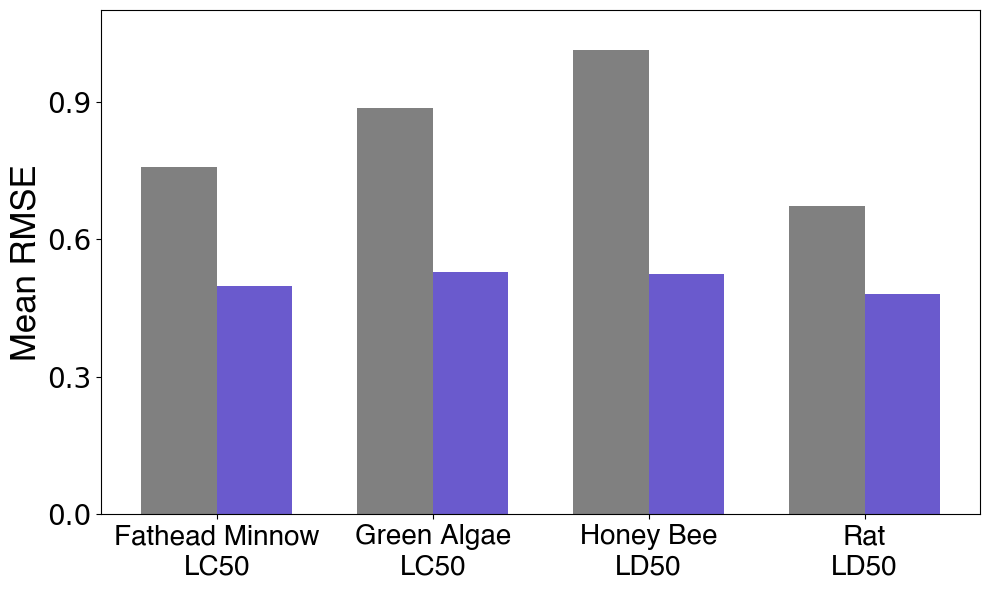

In [168]:
# Data for each category
categories = ['Fathead Minnow\nLC50', 'Green Algae\nLC50', 'Honey Bee\nLD50', 'Rat\nLD50']
global_rmse_true = [0.758009, 0.885441, 1.012975, 0.671645]  
RSP_rmse_true = [0.498791, 0.527876, 0.525062, 0.480466]

x = np.arange(len(categories))
width = 0.35  # Bar width adjusted for 3 bars per category

# Define positions for each set of bars
pos_global = x - width/2
pos_RSP = x + width/2

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
ax.bar(pos_global, global_rmse_true, width, color='gray', label='Global')
ax.bar(pos_RSP, RSP_rmse_true, width, color='slateblue', label='RSP')

# Labels, ticks, and title
ax.set_ylabel('Mean RMSE', fontsize=25, fontname='Helvetica')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=20, fontname='Helvetica')
ax.set_yticks(np.linspace(0, 1.2, 5))
ax.tick_params(axis='y', labelsize=20)

# Set y-axis limit
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()


Distance - error correlations

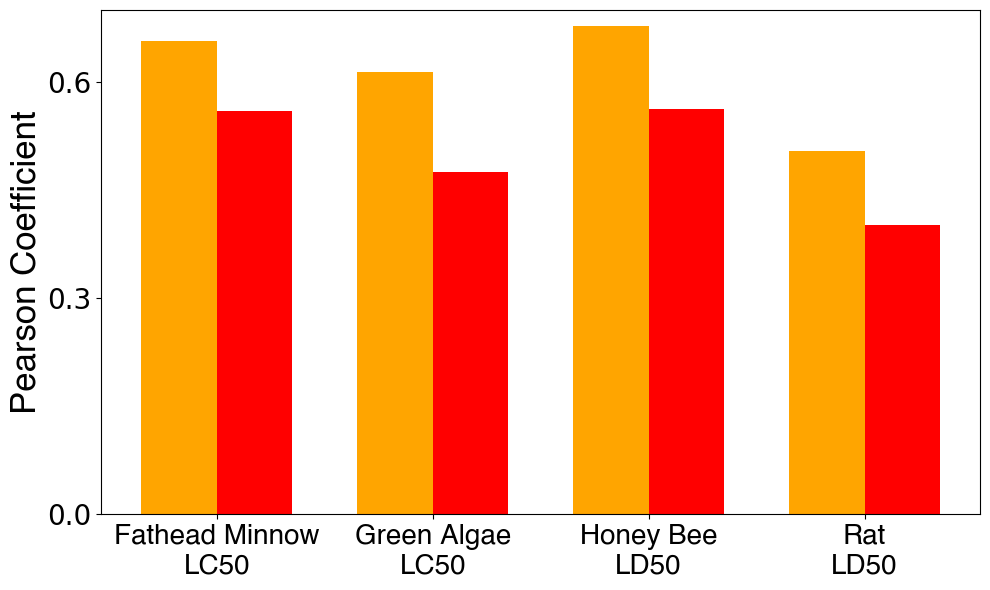

In [169]:
# Data for each category
categories = ['Fathead Minnow\nLC50', 'Green Algae\nLC50', 'Honey Bee\nLD50', 'Rat\nLD50']
train_r = [0.656339, 0.614007, 0.677785, 0.504153]  
test_r = [0.559279, 0.475298, 0.562382, 0.400989]

x = np.arange(len(categories))
width = 0.35  # Bar width adjusted for 3 bars per category

# Define positions for each set of bars
pos_global = x - width/2
pos_RSP = x + width/2

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
ax.bar(pos_global, train_r, width, color='orange')
ax.bar(pos_RSP, test_r, width, color='r', label='RSP')

# Labels, ticks, and title
ax.set_ylabel('Pearson Coefficient', fontsize=25, fontname='Helvetica')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=20, fontname='Helvetica')
ax.set_yticks(np.linspace(0, 0.6, 3))
ax.tick_params(axis='y', labelsize=20)

# Set y-axis limit
ax.set_ylim(0, 0.7)

plt.tight_layout()
plt.show()


UQ Coverage (Truly in-domain molecules)

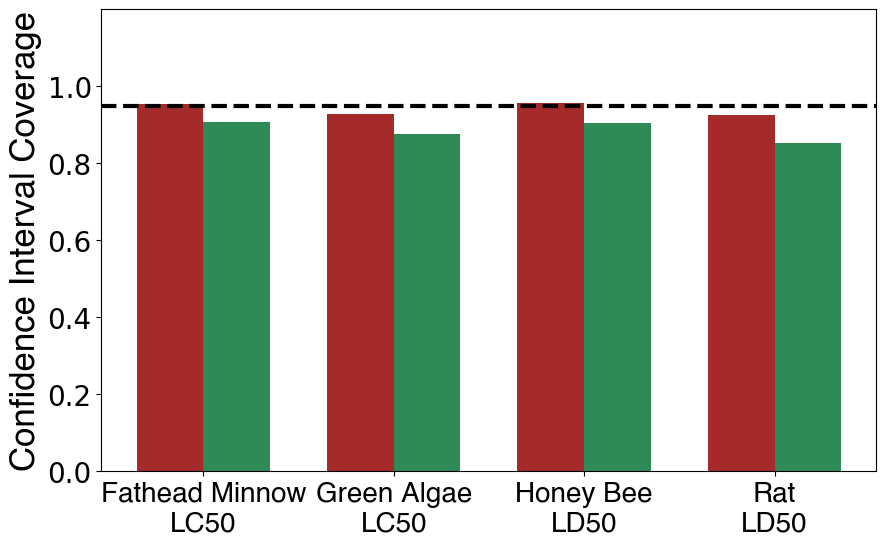

Across the datasets, dcp showed 4.7%, 5.4%, 5.0%, 7.3% higher coverage with 20.8%, 24.0%, 29.8%, 27.0% wider intervals.


In [185]:
# Predicted to be in domain
categories = ['Fathead Minnow\nLC50', 'Green Algae\nLC50', 'Honey Bee\nLD50', 'Rat\nLD50']
CI_cov_dcp = np.array([0.955060 , 0.929284,  0.955434, 0.925359])
CI_cov_fcp = np.array([0.908274, 0.874840, 0.905616, 0.852059])

x = np.arange(len(categories))
width = 0.35  # Bar width
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Updated colors
ax.bar(x - width/2, CI_cov_dcp, width, color='brown')  # Warm & vibrant
ax.bar(x + width/2, CI_cov_fcp, width, color='seagreen')  # Cool & distinct
ax.axhline(y=0.95, color='black', linestyle='dashed', linewidth=3)


# Labels, ticks, and title
ax.set_ylabel('Confidence Interval Coverage', fontsize=25, fontname='Helvetica')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=20, fontname='Helvetica')

# Adjust Y-axis ticks
ax.set_yticks(np.linspace(0, 1.0, 6))
ax.set_ylim(0.0, 1.2)
ax.tick_params(axis='y', labelsize=20)

plt.show()

CI_width_dcp = np.array([2.100752 , 2.116697,  2.391443, 1.829091])
CI_width_fcp = np.array([1.739692, 1.706505, 1.841960, 1.439686])

# Format the arrays into comma-separated strings with 2 decimal places
coverage_diff = 100 * (CI_cov_dcp - CI_cov_fcp)
interval_diff = 100 * (CI_width_dcp - CI_width_fcp) / CI_width_fcp

coverage_str = ', '.join([f"{val:.1f}%" for val in coverage_diff])
interval_str = ', '.join([f"{val:.1f}%" for val in interval_diff])

print(f"Across the datasets, dcp showed {coverage_str} higher coverage with {interval_str} wider intervals.")



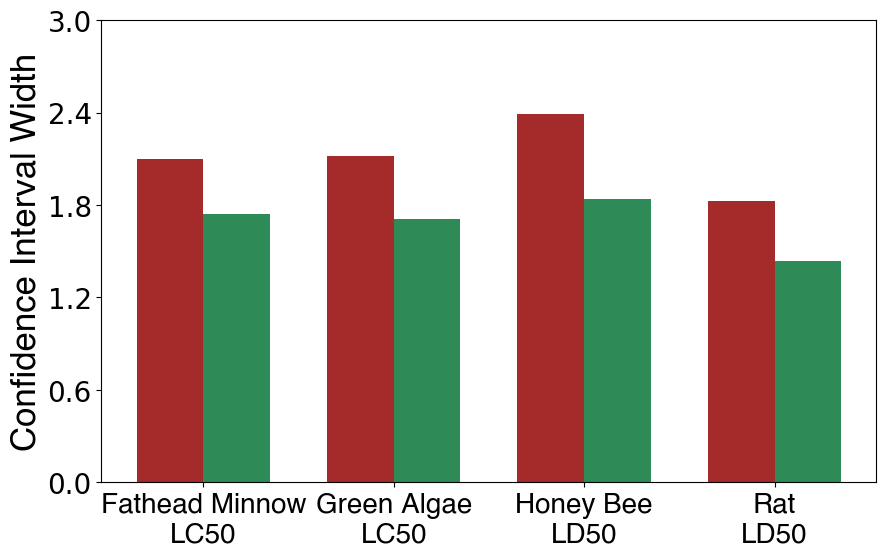

In [187]:
# Predicted to be in domain
categories = ['Fathead Minnow\nLC50', 'Green Algae\nLC50', 'Honey Bee\nLD50', 'Rat\nLD50']
CI_width_dcp = np.array([2.100752 , 2.116697,  2.391443, 1.829091])
CI_width_fcp = np.array([1.739692, 1.706505, 1.841960, 1.439686])

x = np.arange(len(categories))
width = 0.35  # Bar width
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Updated colors
ax.bar(x - width/2, CI_width_dcp, width, color='brown')  # Warm & vibrant
ax.bar(x + width/2, CI_width_fcp, width, color='seagreen')  # Cool & distinct


# Labels, ticks, and title
ax.set_ylabel('Confidence Interval Width', fontsize=25, fontname='Helvetica')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=20, fontname='Helvetica')

# Adjust Y-axis ticks
ax.set_yticks(np.linspace(0, 3.0, 6))
ax.set_ylim(0.0, 3.0)
ax.tick_params(axis='y', labelsize=20)

plt.show()

